In [135]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""

# Import tf if using backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
import deepxde as dde
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import plotly.graph_objects as go
import sympy as sp
import scipy.integrate as spi
from scipy.interpolate import interp1d





def generate_evolution_model(domain, boundary, width, depth, rate, epochs):
    
    def pde(x, y):
        # y = (f)
        # x = (x,y,z)
        # x = x[:,0:1]
        # y = x[:,1:2]
        # z = x[:,2:]
        df_x = dde.grad.jacobian(y, x, i=0, j=0)
        df_y = dde.grad.jacobian(y, x, i=0, j=1)
        df_z = dde.grad.jacobian(y, x, i=0, j=2)
        first_factor = (x[:,0:1]**2 + x[:,1:2]**2)/(x[:,0:1]**2 + x[:,1:2]**2 + x[:,2:3]**2)
        squared_terms = ((x[:,0:1]**2)*(df_x)) + ((x[:,1:2]**2)*(df_y)) + ((x[:,2:]**2)*(df_z))
        cross_terms =  (x[:,0:1] * x[:,1:2] * df_x * df_y)+(x[:,0:1] * x[:,2:] * df_x * df_z)+(x[:,1:2] * x[:,2:] * df_y * df_z)
        return first_factor * (squared_terms + (2*cross_terms)) - 0.5

    

    geom = dde.geometry.geometry_3d.Cuboid([-10,-10,-10],[10,10,10])
   
    # singularity = dde.geometry.geometry_3d.Sphere([0,0,0], 0.1)



    icx_1 = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[0],1),
    )
    
    
    
    icx_2 = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[0],10),
    )
    
    
    
    
    icy_1 = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[1],-1),
    )
    
    icy_2 = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[1],10),
    )
    
    
    
    
    
    
    icz_1 = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[2],-1),
    )
    
    icz_2 = dde.icbc.DirichletBC(
        geom,
        lambda x: 1,
        lambda x, on_boundary:  np.isclose(x[2],10),
    )
    
    
    
    

    data = dde.data.PDE(
        geom, pde, [icx_2, icy_2,icz_2], num_domain=domain, num_boundary=boundary)


    net = dde.nn.FNN([3] + [width] * depth + [1], "tanh", "Glorot normal")


    model = dde.Model(data, net)
    model.compile("adam", lr=rate)
    losshistory, train_state = model.train(iterations=epochs)
    dde.saveplot(losshistory, train_state, issave=True, isplot=True)

    
    
    print("Training Complete!")

    return model




Compiling model...
Building feed-forward neural network...
'build' took 0.024177 s

'compile' took 1.021813 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.68e+01, 7.66e-01, 6.13e-01, 3.86e+00]    [7.68e+01, 7.66e-01, 6.13e-01, 3.86e+00]    []  
1000      [3.91e-02, 1.70e-03, 8.46e-04, 2.52e-03]    [3.91e-02, 1.70e-03, 8.46e-04, 2.52e-03]    []  
2000      [3.49e-02, 1.67e-03, 7.31e-04, 2.57e-03]    [3.49e-02, 1.67e-03, 7.31e-04, 2.57e-03]    []  
3000      [2.77e-02, 2.20e-03, 6.86e-04, 2.55e-03]    [2.77e-02, 2.20e-03, 6.86e-04, 2.55e-03]    []  
4000      [2.18e-02, 1.27e-03, 1.15e-03, 2.27e-03]    [2.18e-02, 1.27e-03, 1.15e-03, 2.27e-03]    []  
5000      [2.12e-02, 1.40e-03, 1.15e-03, 2.08e-03]    [2.12e-02, 1.40e-03, 1.15e-03, 2.08e-03]    []  
6000      [2.23e-02, 1.44e-03, 1.29e-03, 2.36e-03]    [2.23e-02, 1.44e-03, 1.29e-03, 2.36e-03]    []  
7000      [2.13e-02, 1.35e-03, 1.12e-03

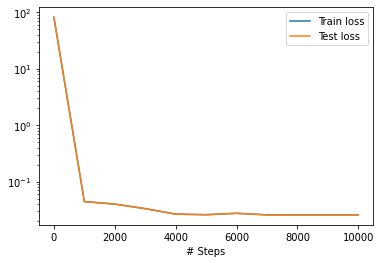

Training Complete!


In [136]:
model = generate_evolution_model(500, 500, 10, 1, 0.01, 10000)

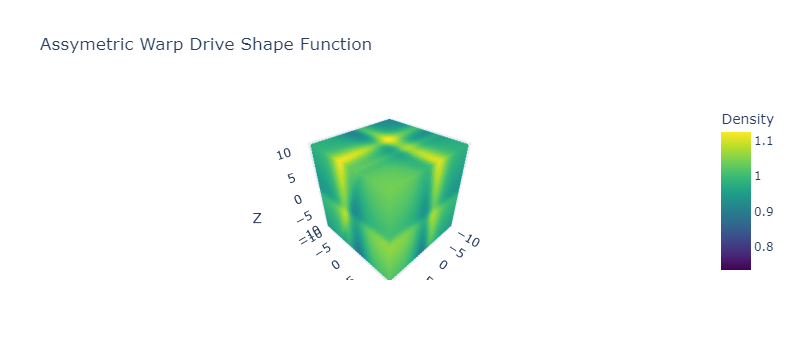

In [137]:
import numpy as np
import plotly.graph_objs as go

# Generate sample data points
x_values = np.linspace(-10, 10, 30)
y_values = np.linspace(-10, 10, 30)
z_values = np.linspace(-10, 10, 30)
X, Y, Z = np.meshgrid(x_values, y_values, z_values)

# Evaluate the model on the data points
input_data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
predictions = model.predict(input_data)
predictions = predictions.reshape(X.shape)

# Create the 3D density plot with Plotly using the 'Viridis' color scale
fig = go.Figure(data=[
    go.Scatter3d(x=X.ravel(), y=Y.ravel(), z=Z.ravel(), mode='markers',
                 marker=dict(size=3, color=predictions.ravel(), colorscale='viridis', colorbar=dict(title='Density'))),
])

fig.update_layout(scene=dict(
                    xaxis_title='X',
                    yaxis_title='Y',
                    zaxis_title='Z'),
                  title='Assymetric Warp Drive Shape Function')

fig.show()


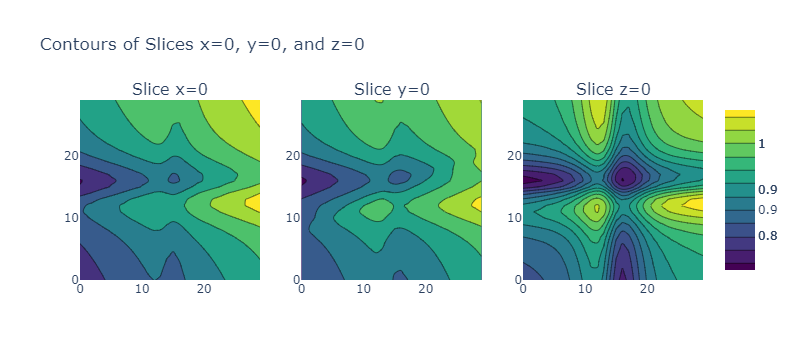

In [138]:
import numpy as np
import plotly.subplots as sp
import plotly.graph_objs as go

# Generate sample data points
x_values = np.linspace(-10, 10, 30)
y_values = np.linspace(-10, 10, 30)
z_values = np.linspace(-10, 10, 30)
X, Y, Z = np.meshgrid(x_values, y_values, z_values)

# Evaluate the model on the data points (assuming you have 'model' defined somewhere)
input_data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
predictions = model.predict(input_data)
predictions = predictions.reshape(X.shape)

# Create contour plots for slices x=0, y=0, and z=0
contour_x0 = go.Contour(z=predictions[15, :, :], colorscale='Viridis')
contour_y0 = go.Contour(z=predictions[:, 15, :], colorscale='Viridis')
contour_z0 = go.Contour(z=predictions[:, :, 15], colorscale='Viridis')

# Create subplots
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=('Slice x=0', 'Slice y=0', 'Slice z=0'))

# Add contour plots to subplots
fig.add_trace(contour_x0, row=1, col=1)
fig.add_trace(contour_y0, row=1, col=2)
fig.add_trace(contour_z0, row=1, col=3)

# Update layout
fig.update_layout(title='Contours of Slices x=0, y=0, and z=0')

fig.show()


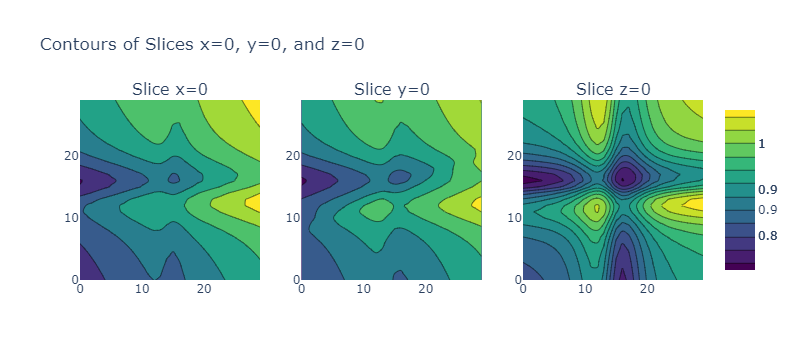

In [139]:
import numpy as np
import plotly.subplots as sp
import plotly.graph_objs as go

# Generate sample data points
x_values = np.linspace(-10, 10, 30)
y_values = np.linspace(-10, 10, 30)
z_values = np.linspace(-10, 10, 30)
X, Y, Z = np.meshgrid(x_values, y_values, z_values)

# Evaluate the model on the data points (assuming you have 'model' defined somewhere)
input_data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
# Assuming you have some model defined that returns predictions
predictions = model.predict(input_data)
predictions = predictions.reshape(X.shape)

# Create contour plots for slices x=0, y=0, and z=0
contour_x0 = go.Contour(z=predictions[15, :, :], colorscale='Viridis', hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>Value: %{z:.2f}')
contour_y0 = go.Contour(z=predictions[:, 15, :], colorscale='Viridis', hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>Value: %{z:.2f}')
contour_z0 = go.Contour(z=predictions[:, :, 15], colorscale='Viridis', hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>Value: %{z:.2f}')

# Create subplots
fig = sp.make_subplots(rows=1, cols=3, subplot_titles=('Slice x=0', 'Slice y=0', 'Slice z=0'))

# Add contour plots to subplots
fig.add_trace(contour_x0, row=1, col=1)
fig.add_trace(contour_y0, row=1, col=2)
fig.add_trace(contour_z0, row=1, col=3)

# Update layout
fig.update_layout(title='Contours of Slices x=0, y=0, and z=0')

fig.show()


In [149]:
import numpy as np
import plotly.graph_objs as go

# Assuming you have the 'model' and 'predictions' defined as in your code

# Generate sample data points
x_values = np.linspace(-10, 10, 30)
y_values = np.linspace(-10, 10, 30)
z_values = np.linspace(-10, 10, 30)
X, Y, Z = np.meshgrid(x_values, y_values, z_values)

# Evaluate the model on the data points
input_data = np.vstack((X.ravel(), Y.ravel(), Z.ravel())).T
predictions = model.predict(input_data)
predictions = predictions.reshape(X.shape)

# Define the slices for x=0, y=0, z=0
x_slice = 0
y_slice = 0
z_slice = 0

# Plot the 3D surface for x=0 slice
fig_x = go.Figure(data=[go.Surface(z=Y[x_slice, :, :], y=Z[x_slice, :, :], x=predictions[x_slice, :, :])])
fig_x.update_layout(title='Slice for x=0')
fig_x.show()

# Plot the 3D surface for y=0 slice
fig_y = go.Figure(data=[go.Surface(x=X[:, y_slice, :], z=Z[:, y_slice, :], y=predictions[:, y_slice, :])])
fig_y.update_layout(title='Slice for y=0')
fig_y.show()

# Plot the 3D surface for z=0 slice
fig_z = go.Figure(data=[go.Surface(x=X[:, :, z_slice], y=Y[:, :, z_slice], z=predictions[:, :, z_slice])])
fig_z.update_layout(title='Slice for z=0')
fig_z.show()
